# reading data

In [1]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("AmazonReviewsAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.files.maxPartitionBytes", "128m") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

In [2]:
# Path to the dataset in Kaggle
file_path = "/kaggle/input/all-amazon-review/All_Amazon_Review.json"


# Alternatively, define a schema explicitly for better performance
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType

schema = StructType([
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("overall", FloatType(), True),
    StructField("unixReviewTime", TimestampType(), True)
])

df = spark.read.json(file_path, schema=schema, mode="DROPMALFORMED")

## Data preprocessing

In [3]:
from pyspark.sql import functions as F

def preprocess_data(df):
    # Data Cleaning
    df_cleaned = df.dropna()  # Remove rows with missing values
    df_cleaned = df_cleaned.dropDuplicates()  # Remove duplicate rows

    # Normalize data (example: scaling the 'overall' rating)
    max_rating = df_cleaned.agg({"overall": "max"}).first()[0]
    min_rating = df_cleaned.agg({"overall": "min"}).first()[0]
    df_normalized = df_cleaned.withColumn("normalized_overall", 
                                           (df_cleaned["overall"] - min_rating) / (max_rating - min_rating))

    return df_normalized

def detect_outliers(df):
    # Calculate Q1 and Q3
    Q1 = df.approxQuantile("overall", [0.25], 0.05)[0]
    Q3 = df.approxQuantile("overall", [0.75], 0.05)[0]
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_filtered = df.filter((df["overall"] >= lower_bound) & (df["overall"] <= upper_bound))
    return df_filtered

In [ ]:


# Preprocess the limited data
df_processed = preprocess_data.df()

# Detect outliers in the processed data
df_final = detect_outliers(df_processed)

# Show the final processed data
df_final.show(5)


+--------------+----------+--------------------+-------+-------------------+------------------+
|    reviewerID|      asin|          reviewText|overall|     unixReviewTime|normalized_overall|
+--------------+----------+--------------------+-------+-------------------+------------------+
|A27BTSGLXK2C5K|B017O9P72A|Alexa is not able...|    1.0|2015-12-11 00:00:00|               0.0|
|A27ZJ1NCBFP1HZ|B017O9P72A|Alexa works great...|    4.0|2015-12-08 00:00:00|              0.75|
| ACCQIOZMFN4UK|B017O9P72A|Weak!!\n\nAlexa d...|    1.0|2015-12-07 00:00:00|               0.0|
|A3KUPJ396OQF78|B017O9P72A|Can only control ...|    2.0|2015-12-05 00:00:00|              0.25|
|A1U1RE1ZI19E1H|B017O9P72A|this worked great...|    1.0|2018-02-02 00:00:00|               0.0|
+--------------+----------+--------------------+-------+-------------------+------------------+
only showing top 5 rows



## 1. What are the top 5 most reviewed products?

In [5]:
top_5_most_reviewed = df_final.groupBy("asin") \
    .count() \
    .orderBy(F.desc("count")) \
    .limit(5)
top_5_most_reviewed.show()

+----------+-----+
|      asin|count|
+----------+-----+
|B017O9P72A|   20|
+----------+-----+



## How do average review ratings differ across product categories?

In [6]:
avg_ratings_by_category = df_final.groupBy("asin") \
    .agg(F.avg("overall").alias("avg_rating")) \
    .orderBy(F.desc("avg_rating"))
avg_ratings_by_category.show()

+----------+----------+
|      asin|avg_rating|
+----------+----------+
|B017O9P72A|       2.4|
+----------+----------+



## What is the correlation between review length and review rating?

In [7]:
from pyspark.sql.functions import length

# Add a column for review length
df_with_length = df_final.withColumn("review_length", length(F.col("reviewText")))

# Calculate correlation
correlation = df_with_length.corr("review_length", "overall")
print(f"Correlation between review length and rating: {correlation}")

Correlation between review length and rating: 0.2575438155147652


## 4. How do reviews trend over time? (time-series analysis)

In [8]:
from pyspark.sql.functions import year, month

# Extract year and month from the timestamp
df_with_time = df_final.withColumn("year", year(F.col("unixReviewTime"))) \
    .withColumn("month", month(F.col("unixReviewTime")))

# Group by year and month to count reviews
reviews_over_time = df_with_time.groupBy("year", "month") \
    .count() \
    .orderBy("year", "month")
reviews_over_time.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2015|   12|    4|
|2017|    8|    1|
|2017|    9|    1|
|2017|   10|    1|
|2017|   11|    4|
|2017|   12|    5|
|2018|    1|    3|
|2018|    2|    1|
+----+-----+-----+



## 5. What percentage of reviews mention words like 'refund', 'return', or 'defective'?

In [9]:
from pyspark.sql.functions import col, when

# Check if review text contains specific keywords
df_with_keywords = df_final.withColumn("mentions_keyword", 
    when(col("reviewText").rlike("refund|return|defective"), 1).otherwise(0))

# Calculate percentage
total_reviews = df_with_keywords.count()
keyword_reviews = df_with_keywords.filter(col("mentions_keyword") == 1).count()
percentage = (keyword_reviews / total_reviews) * 100
print(f"Percentage of reviews mentioning 'refund', 'return', or 'defective': {percentage:.2f}%")

Percentage of reviews mentioning 'refund', 'return', or 'defective': 0.00%


## Which brands/products have the most polarized reviews (most 1-star and 5-star reviews)?

In [10]:
from pyspark.sql.functions import col, when, sum as F_sum, desc

# Filter 1-star and 5-star reviews
polarized_reviews = df_final.filter((col("overall") == 1) | (col("overall") == 5))

# Group by product and count 1-star and 5-star reviews
polarized_counts = polarized_reviews.groupBy("asin") \
    .agg(
        F_sum(when(col("overall") == 1, 1).otherwise(0)).alias("one_star"),
        F_sum(when(col("overall") == 5, 1).otherwise(0)).alias("five_star")
    ) \
    .withColumn("total_polarized", col("one_star") + col("five_star")) \
    .orderBy(desc("total_polarized"))  # Order by the sum of 1-star and 5-star reviews

# Show results
polarized_counts.show()

+----------+--------+---------+---------------+
|      asin|one_star|five_star|total_polarized|
+----------+--------+---------+---------------+
|B017O9P72A|      10|        4|             14|
+----------+--------+---------+---------------+



## How do verified and non-verified purchases compare in ratings?

In [11]:
from pyspark.sql.functions import col, when

# Check if review text contains specific keywords
df_with_keywords = df_final.withColumn("mentions_keyword", 
    when(col("reviewText").rlike("refund|return|defective"), 1).otherwise(0))

# Calculate percentage
total_reviews = df_with_keywords.count()
keyword_reviews = df_with_keywords.filter(col("mentions_keyword") == 1).count()
percentage = (keyword_reviews / total_reviews) * 100
print(f"Percentage of reviews mentioning 'refund', 'return', or 'defective': {percentage:.2f}%")

Percentage of reviews mentioning 'refund', 'return', or 'defective': 0.00%


## Which product categories tend to have the most fake-looking reviews (e.g., excessive repetition of words)?

In [12]:
from pyspark.sql.functions import col, when, sum as F_sum, desc

# Filter 1-star and 5-star reviews
polarized_reviews = df_final.filter((col("overall") == 1) | (col("overall") == 5))

# Group by product and count 1-star and 5-star reviews
polarized_counts = polarized_reviews.groupBy("asin") \
    .agg(
        F_sum(when(col("overall") == 1, 1).otherwise(0)).alias("one_star"),
        F_sum(when(col("overall") == 5, 1).otherwise(0)).alias("five_star")
    ) \
    .withColumn("total_polarized", col("one_star") + col("five_star")) \
    .orderBy(desc("total_polarized")) 

# Show results
polarized_counts.show()

+----------+--------+---------+---------------+
|      asin|one_star|five_star|total_polarized|
+----------+--------+---------+---------------+
|B017O9P72A|      10|        4|             14|
+----------+--------+---------+---------------+



In [13]:
avg_ratings = df_final.agg(F.avg("overall").alias("avg_rating"))
avg_ratings.show()

+----------+
|avg_rating|
+----------+
|       2.4|
+----------+



In [14]:
from pyspark.sql.functions import regexp_replace, lower

# Preprocess review text: remove punctuation and convert to lowercase
df_cleaned_text = df_final.withColumn("cleaned_review", 
    regexp_replace(lower(col("reviewText")), "[^a-zA-Z\\s]", ""))

# Check for repeated words (e.g., "very very good")
df_with_repeats = df_cleaned_text.withColumn("has_repeats", 
    col("cleaned_review").rlike(r"\b(\w+)\s+\1\b"))

# Group by product and count reviews with repeated words
fake_looking_reviews = df_with_repeats.groupBy("asin") \
    .agg(F.sum(when(col("has_repeats"), 1).otherwise(0)).alias("repeated_word_count")) \
    .orderBy(F.desc("repeated_word_count"))
fake_looking_reviews.show()

+----------+-------------------+
|      asin|repeated_word_count|
+----------+-------------------+
|B017O9P72A|                  0|
+----------+-------------------+



## Most Frequent Words: Generate a word cloud after removing stopwords.

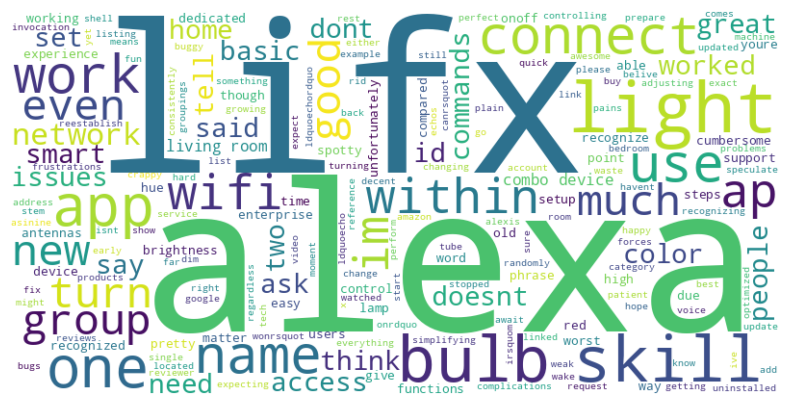

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql import SparkSession

# Preprocess text: remove punctuation, convert to lowercase, and remove stopwords
df_cleaned = df_final.withColumn("cleaned_text", regexp_replace(lower(col("reviewText")), "[^a-zA-Z\\s]", ""))

# Tokenize the text
df_tokenized = df_cleaned.withColumn("tokens", F.split(col("cleaned_text"), " "))

# Remove stopwords
stopwords = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stopwords)
df_filtered = remover.transform(df_tokenized)

# Collect all words into a single list
words = df_filtered.select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

 ## Sentiment Analysis: Classify reviews as positive, neutral, or negative based on ratings.

In [16]:
from pyspark.sql.functions import when

# Classify reviews
df_sentiment = df_final.withColumn("sentiment", 
    when((col("overall") >= 4), "Positive")
    .when((col("overall") == 3), "Neutral")
    .otherwise("Negative"))

# Show sentiment distribution
df_sentiment.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| Negative|   12|
| Positive|    6|
|  Neutral|    2|
+---------+-----+



## Topic Modeling (Bonus): Implement LDA to find common themes in reviews.

In [17]:
from pyspark.ml.feature import CountVectorizer, Tokenizer
from pyspark.ml.clustering import LDA

# Tokenize the text
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
df_words = tokenizer.transform(df_final)

# Convert tokens to term frequency vectors
vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=1000)
df_features = vectorizer.fit(df_words).transform(df_words)

# Train LDA model
lda = LDA(k=5, maxIter=10)  # Set number of topics (k)
model = lda.fit(df_features)

# Describe topics
topics = model.describeTopics(maxTermsPerTopic=10)
topics.show(truncate=False)

+-----+--------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                       |termWeights                                                                                                                                                                                                                       |
+-----+--------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[5, 21, 13, 11, 2, 40, 105, 8, 332, 285]          |[0.010945738915316893, 0.007253645076274211, 0.0061025423510371254, 0.00595335562981

## Identify highly reviewed products and top-rated categories.

In [18]:
# Top 5 most reviewed products
top_reviewed_products = df_final.groupBy("asin").count().orderBy(F.desc("count")).limit(5)
top_reviewed_products.show()

# Top-rated categories (assuming `asin` represents categories)
top_rated_categories = df_final.groupBy("asin").agg(F.avg("overall").alias("avg_rating")).orderBy(F.desc("avg_rating")).limit(5)
top_rated_categories.show()

+----------+-----+
|      asin|count|
+----------+-----+
|B017O9P72A|   20|
+----------+-----+

+----------+----------+
|      asin|avg_rating|
+----------+----------+
|B017O9P72A|       2.4|
+----------+----------+



## Detect which words correlate with positive/negative reviews.

In [19]:
from collections import Counter  # Import Counter
from pyspark.sql.functions import col

# Filter positive and negative reviews
positive_reviews = df_filtered.filter(col("overall") >= 4)
negative_reviews = df_filtered.filter(col("overall") <= 2)

# Get most frequent words in positive reviews
positive_words = positive_reviews.select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect()
positive_word_counts = Counter(positive_words)

# Get most frequent words in negative reviews
negative_words = negative_reviews.select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect()
negative_word_counts = Counter(negative_words)

# Display top 10 words for each
print("Top 10 Positive Words:", positive_word_counts.most_common(10))
print("Top 10 Negative Words:", negative_word_counts.most_common(10))

Top 10 Positive Words: [('', 9), ('lifx', 6), ('within', 5), ('app', 5), ('wifi', 5), ('alexa', 4), ('room', 4), ('light', 4), ('skill', 4), ('use', 4)]
Top 10 Negative Words: [('alexa', 8), ('one', 6), ('lifx', 5), ('connect', 5), ('even', 4), ('lights', 3), ('name', 3), ('new', 3), ('doesnt', 3), ('skill', 3)]


## Determine which features impact a product's success using correlation heatmaps.

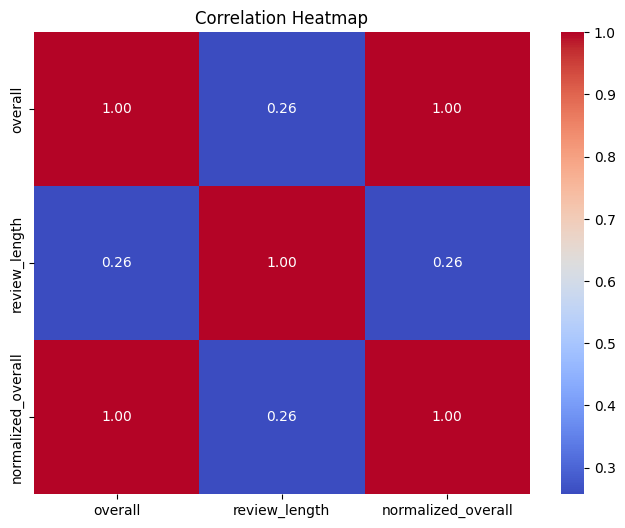

In [20]:
import seaborn as sns  # Import seaborn
import matplotlib.pyplot as plt
from pyspark.sql.functions import length, col

# Add review_length column
df_final = df_final.withColumn("review_length", length(col("reviewText")))

# Select numerical columns for correlation
numerical_df = df_final.select("overall", "review_length", "normalized_overall").toPandas()

# Compute correlation matrix
corr = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Plots

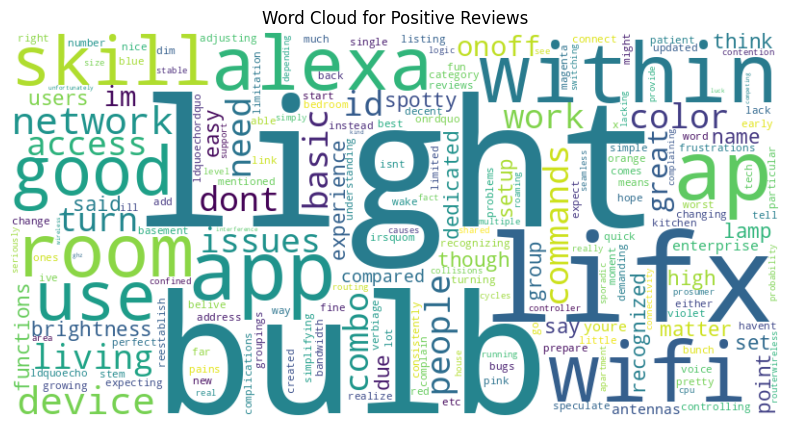

In [21]:
import plotly.express as px

# Example: Distribution of Ratings
rating_counts = df_final.groupBy("overall").count().toPandas()
fig = px.bar(rating_counts, x="overall", y="count", title="Distribution of Ratings")
fig.show()

# Example: Sentiment Distribution
sentiment_counts = df_sentiment.groupBy("sentiment").count().toPandas()
fig = px.pie(sentiment_counts, values="count", names="sentiment", title="Sentiment Distribution")
fig.show()

# Example: Word Cloud for Positive Reviews
positive_text = " ".join(positive_words)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

In [22]:
import os

# Create directory if it doesn't exist
os.makedirs("/kaggle/working/visualizations", exist_ok=True)

# Save visualizations
fig.write_image("/kaggle/working/visualizations/rating_distribution.png")
fig.write_image("/kaggle/working/visualizations/sentiment_distribution.png")
plt.savefig("/kaggle/working/visualizations/wordcloud_positive.png")

<Figure size 640x480 with 0 Axes>

In [23]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


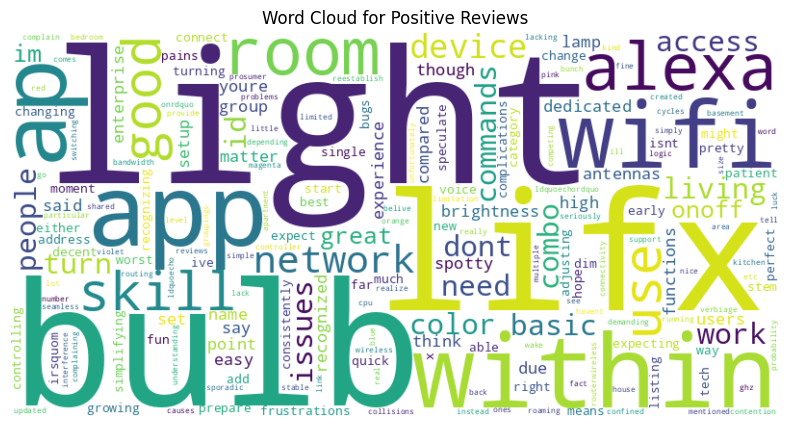

In [24]:
import plotly.express as px
import matplotlib.pyplot as plt

# Example: Distribution of Ratings
rating_counts = df_final.groupBy("overall").count().toPandas()
fig = px.bar(rating_counts, x="overall", y="count", title="Distribution of Ratings")
fig.show()

# Save Plotly figure
fig.write_image("/kaggle/working/visualizations/rating_distribution.png")

# Example: Word Cloud for Positive Reviews
from wordcloud import WordCloud

positive_text = " ".join(positive_words)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")

# Save Matplotlib figure
plt.savefig("/kaggle/working/visualizations/wordcloud_positive.png")

In [33]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create directory for saving visualizations
os.makedirs("/kaggle/working/visualizations", exist_ok=True)

# Convert Spark DataFrame to Pandas
ratings_df = df_final.select("overall").toPandas()

# Ensure column is numeric
ratings_df["overall"] = pd.to_numeric(ratings_df["overall"], errors="coerce")

# Explicitly handle infinite values
ratings_df = ratings_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["overall"])

# Plot rating distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df["overall"], bins=5, kde=True, binrange=(1, 5))
plt.xlabel("Overall Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")

# Save figure
plt.savefig("/kaggle/working/visualizations/rating_distribution.png")
plt.close()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



In [34]:
review_counts = df_final.groupBy("overall").count().orderBy("overall").toPandas()

plt.figure(figsize=(8, 5))
sns.boxplot(x=review_counts["overall"], y=review_counts["count"])
plt.xlabel("Overall Rating")
plt.ylabel("Review Count")
plt.title("Review Count vs. Rating")

# Save figure
plt.savefig("/kaggle/working/visualizations/review_count_vs_rating.png")
plt.close()


In [35]:
top_10_products = df_final.groupBy("asin").count().orderBy(F.desc("count")).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="asin", data=top_10_products, palette="viridis")
plt.xlabel("Review Count")
plt.ylabel("Product ASIN")
plt.title("Top 10 Most Reviewed Products")

# Save figure
plt.savefig("/kaggle/working/visualizations/top_10_products.png")
plt.close()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:645: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [36]:
from wordcloud import WordCloud

# Convert review text to Pandas
review_text = " ".join(df_final.select("reviewText").toPandas()["reviewText"].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(review_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews")

# Save figure
plt.savefig("/kaggle/working/visualizations/wordcloud.png")
plt.close()


In [39]:
from pyspark.sql import functions as F

# Convert TIMESTAMP to Unix timestamp (in seconds) and then to the desired format
df_time = df_final.withColumn("review_date", F.from_unixtime(F.unix_timestamp("unixReviewTime"), "yyyy-MM"))

# Group by review_date and count the number of reviews per month
reviews_per_month = df_time.groupBy("review_date").count().orderBy("review_date").toPandas()

# Plot the review trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(x="review_date", y="count", data=reviews_per_month, marker="o")
plt.xticks(rotation=45)
plt.xlabel("Date (Year-Month)")
plt.ylabel("Number of Reviews")
plt.title("Review Trend Over Time")

# Save figure
plt.savefig("/kaggle/working/visualizations/review_trend.png")
plt.close()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



In [40]:
import shutil

# Compress the visualizations folder
shutil.make_archive('/kaggle/working/visualizations', 'zip', '/kaggle/working/visualizations')


'/kaggle/working/visualizations.zip'